## 1. Memuat Data

**Alasan**: Kita mulai dengan masukin dataset dari file `train.csv` ke dalam DataFrame pandas biar datanya gampang diolah. Habis itu, kita intip lima baris pertamanya buat mastiin data udah kebaca bener.

In [31]:
import pandas as pd

# Muat dataset
df = pd.read_csv('/content/train.csv', sep=';')

# Tampilkan lima baris pertama
print("Lima baris pertama dari DataFrame:")
display(df.head())

Lima baris pertama dari DataFrame:


,id,year,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,3,2012,23,3,0,0,2,23.78,27.275,73,11.0014,133
1,4,2011,8,3,0,0,1,27.88,31.820,57,0.0000,132
2,5,2012,2,1,0,1,1,20.50,24.240,59,0.0000,19
3,7,2011,20,3,0,1,3,25.42,28.790,83,19.9995,58
4,8,2011,17,3,0,1,3,26.24,28.790,89,0.0000,285


## 2. Pembersihan Data

**Alasan**: Sekarang kita cek data kita, ada yang bolong (nilai hilang) atau ada baris yang sama persis (duplikat) nggak. Penting nih biar data kita bersih sebelum dianalisis lebih lanjut.

In [22]:
# Cek nilai yang hilang
print("Jumlah nilai yang hilang per kolom:")
display(df.isnull().sum())

# Cek baris duplikat
print("\nJumlah baris duplikat:")
display(df.duplicated().sum())

Jumlah nilai yang hilang per kolom:


,0
id;year;hour;season;holiday;workingday;weather;temp;atemp;humidity;windspeed;count,0



Jumlah baris duplikat:


np.int64(0)

**Alasan**: Karena nggak ada data yang hilang atau duplikat, data kita udah lumayan bersih. Selanjutnya, kita cek statistik dasar buat kolom-kolom angka buat nyari tau ada yang aneh, misalnya ada outlier gitu.

In [32]:
# Tampilkan statistik deskriptif
print("Statistik deskriptif untuk kolom numerik:")
display(df.describe())

Statistik deskriptif untuk kolom numerik:


,id,year,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000
mean,5463.266224,2011.495513,11.565353,2.506178,0.029002,0.677331,1.410066,20.267085,23.696581,61.771492,12.802070,191.419430
std,3144.709810,0.500012,6.915777,1.115935,0.167824,0.467528,0.628004,7.824066,8.514199,19.302151,8.178889,182.140265
min,3.000000,2011.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,1.000000
25%,2771.000000,2011.000000,6.000000,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,41.000000
50%,5477.000000,2011.000000,12.000000,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,145.000000
75%,8186.000000,2012.000000,18.000000,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,283.000000
max,10886.000000,2012.000000,23.000000,4.000000,1.000000,1.000000,3.000000,41.000000,45.455000,100.000000,56.996900,977.000000


**Alasan**: Dari statistik deskriptif, kayaknya ada nilai ekstrem (outlier) di kolom `count`. Biar lebih yakin dan keliatan sebarannya, kita bikin box plot buat kolom `count`.

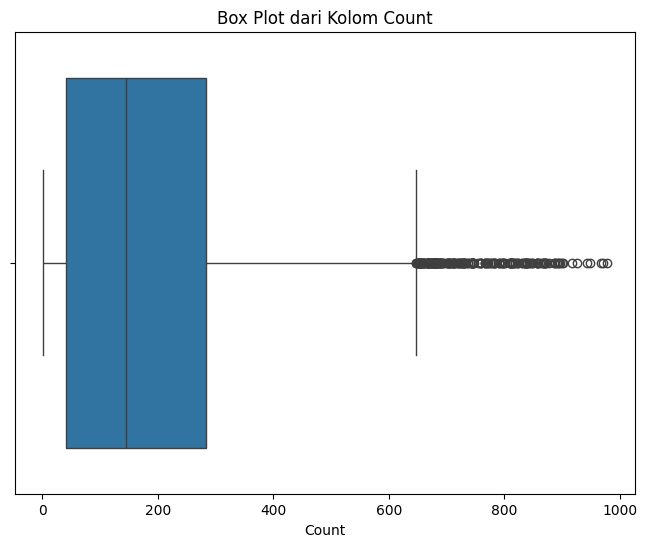

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x=df['count'])
plt.title('Box Plot dari Kolom Count')
plt.xlabel('Count')
plt.show()

**Alasan**: Box plot tadi jelasin kalo emang ada outlier di kolom `count`. Buat ngatasin ini biar nggak ganggu model, kita pake metode capping. Jadi, nilai yang di atas persentil ke-99 bakal diganti sama nilai persentil ke-99 itu sendiri.

In [34]:
import numpy as np

# Tentukan nilai persentil ke-99
q99 = df['count'].quantile(0.99)

# Ganti outlier dengan nilai persentil ke-99
df['count'] = df['count'].clip(upper=q99)

print(f"Outlier di kolom 'count' sudah diganti sampai nilai di persentil ke-99 ({q99}).")

# Cek lagi statistik kolom 'count' setelah capping
print("\nStatistik deskriptif untuk kolom 'count' setelah penanganan outlier:")
display(df['count'].describe())

Outlier di kolom 'count' sudah diganti sampai nilai di persentil ke-99 (782.0).

Statistik deskriptif untuk kolom 'count' setelah penanganan outlier:


,count
count,7689.000000
mean,190.761738
std,179.816361
min,1.000000
25%,41.000000
50%,145.000000
75%,283.000000
max,782.000000


## 3. Normalisasi/Standarisasi Kolom Numerik

**Alasan**: Kolom-kolom angka punya rentang nilai yang beda-beda. Biar adil dan nggak ada kolom yang mendominasi cuma gara-gara angkanya gede, kita samain skalanya pake `StandardScaler`. Ini bikin data kita punya rata-rata nol dan standar deviasi satu.

In [35]:
from sklearn.preprocessing import StandardScaler

# Pilih kolom angka yang mau diubah skalanya (selain 'id' dan 'count')
numerical_cols = ['year', 'hour', 'temp', 'atemp', 'humidity', 'windspeed']

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Aplikasikan scaling ke kolom-kolom yang udah dipilih
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Kolom-kolom angka sudah diubah skalanya pakai StandardScaler.")
display(df.head())

Kolom-kolom angka sudah diubah skalanya pakai StandardScaler.


,id,year,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,3,1.009014,1.653522,3,0,0,2,0.449018,0.420316,0.581761,-0.220175,133
1,4,-0.991066,-0.515573,3,0,0,1,0.973076,0.954165,-0.247216,-1.565360,132
2,5,1.009014,-1.383211,1,0,1,1,0.029771,0.063829,-0.143594,-1.565360,19
3,7,-0.991066,1.219703,3,0,1,3,0.658641,0.598265,1.099872,0.880058,58
4,8,-0.991066,0.785884,3,0,1,3,0.763453,0.598265,1.410738,-1.565360,285


## 4. Encoding Kolom Kategorikal

**Alasan**: Kolom-kolom kategorikal (kayak `season` dan `holiday`) itu isinya teks, bukan angka. Model machine learning nggak bisa langsung ngerti. Jadi, kita ubah jadi angka pake `One-Hot Encoding`. Ini bikin kolom baru buat tiap kategori dan ngasih nilai 0 atau 1. Kita buang salah satu kolom kategori (`drop_first=True`) biar nggak kena masalah *multicollinearity*.

In [36]:
# Identifikasi kolom kategorikal
categorical_cols = ['season', 'holiday', 'workingday', 'weather'] # Tambahkan workingday dan weather

# Aplikasikan one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Kolom kategorikal sudah diubah jadi angka pakai One-Hot Encoding.")
display(df.head())

Kolom kategorikal sudah diubah jadi angka pakai One-Hot Encoding.


,id,year,hour,temp,atemp,humidity,windspeed,count,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3
0,3,1.009014,1.653522,0.449018,0.420316,0.581761,-0.220175,133,False,True,False,False,False,True,False
1,4,-0.991066,-0.515573,0.973076,0.954165,-0.247216,-1.565360,132,False,True,False,False,False,False,False
2,5,1.009014,-1.383211,0.029771,0.063829,-0.143594,-1.565360,19,False,False,False,False,True,False,False
3,7,-0.991066,1.219703,0.658641,0.598265,1.099872,0.880058,58,False,True,False,False,True,False,True
4,8,-0.991066,0.785884,0.763453,0.598265,1.410738,-1.565360,285,False,True,False,False,True,False,True


## 5. Feature Engineering

**Alasan**: Biar model kita makin jago, kita coba bikin fitur baru dari kolom yang udah ada. Ini namanya *feature engineering*. Fitur baru ini bisa nangkep pola yang mungkin nggak keliatan dari kolom aslinya. Kita bikin fitur interaksi antara `year` dan `hour`.

In [37]:
# Buat fitur interaksi antara 'year' dan 'hour'
df['year_hour_interaction'] = df['year'] * df['hour']

print("Fitur baru 'year_hour_interaction' sudah ditambahkan.")
display(df.head())

Fitur baru 'year_hour_interaction' sudah ditambahkan.


,id,year,hour,temp,atemp,humidity,windspeed,count,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,year_hour_interaction
0,3,1.009014,1.653522,0.449018,0.420316,0.581761,-0.220175,133,False,True,False,False,False,True,False,1.668428
1,4,-0.991066,-0.515573,0.973076,0.954165,-0.247216,-1.565360,132,False,True,False,False,False,False,False,0.510967
2,5,1.009014,-1.383211,0.029771,0.063829,-0.143594,-1.565360,19,False,False,False,False,True,False,False,-1.395679
3,7,-0.991066,1.219703,0.658641,0.598265,1.099872,0.880058,58,False,True,False,False,True,False,True,-1.208807
4,8,-0.991066,0.785884,0.763453,0.598265,1.410738,-1.565360,285,False,True,False,False,True,False,True,-0.778863


## 6. Pembagian Data

**Alasan**: Langkah terakhir sebelum masukin ke model, kita bagi data yang udah bersih dan rapi ini jadi dua bagian: buat latihan (training) sama buat ngetes (testing). Tujuannya biar kita bisa ngukur seberapa bagus performa model kita di data yang belum pernah dia liat. Kita bagi 80% buat training dan 20% buat testing.

In [38]:
from sklearn.model_selection import train_test_split

# Tentukan fitur (X) dan target (y)
# Kolom 'count' itu yang mau kita prediksi, jadi dia jadi target (y)
X = df.drop('count', axis=1)
y = df['count']

# Bagi data jadi data training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cetak ukuran masing-masing bagian data buat mastiin
print("Ukuran X_train:", X_train.shape)
print("Ukuran X_test:", X_test.shape)
print("Ukuran y_train:", y_train.shape)
print("Ukuran y_test:", y_test.shape)

Ukuran X_train: (6151, 15)
Ukuran X_test: (1538, 15)
Ukuran y_train: (6151,)
Ukuran y_test: (1538,)
